## libs

In [536]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
#from scipy.interpolate import interp1d
#import scipy.optimize
import scipy.integrate as integrate

## constants

In [537]:
freq_ion = 3.29E15 #Herz
freq_max = 5.0E16 #Herz
alpha = 2.59E-13 #cm^3 per sec
temperature = 40000 #Kelvins
radius_star = 15 * 6.957E5 / (206264.8 * 149.6* 10**6)#pc
r_inner = 0.05 #pc
step = 0.001 #pc

c = 2.99792458E10 #cm per sec , light speed
h = 6.626070040812E-27 #erg*sec, Planck constant
k = 1.380648528E-16 #erg/K, Boltzmann constant
nH_total = 100 #cm^(-3)

In [543]:
freq = np.geomspace (freq_ion, freq_max, 300)
freq_tau = pd.DataFrame(data = {"freq" : freq, "tau_previous" : np.full(300, 0), "tau_current" : np.full(300, 0)})
result = pd.DataFrame(data = {"r" : [r_inner], "n_e" : [100]})
r_previous = r_inner
r_current = r_inner + step 
check = True

## functions

In [544]:
def brightness(freq):
    """mean brightness"""
    return 2 * h * freq**3 / c**2 / (np.exp(h * freq / (k * temperature)) - 1) 
    
def sigma(freq):
    """return photoionization cross section"""
    return 6.3E-18 * np.power (freq_ion / freq, 3)

def tau_step(freq_tau):
    """opacity on distance r"""
    tau_new = 2 * freq_tau['tau_current'] - freq_tau['tau_previous']
    freq_tau['tau_previous'] = freq_tau['tau_current']
    freq_tau['tau_current'] = tau_new 

def tau(result, freq, n_e):
    return integrate.trapz((nH_total - result["n_e"]), result["r"] * (206264.8 * 149.6* 10**11)) * sigma(freq)  

In [545]:
n_e = nH_total
while np.abs(n_e)>0.001:
    check = True
    iteration = 0
    while check:
        PHI = integrate.trapz(m.pi * brightness(freq)  * (radius_star / r_current)**2 * np.exp(-freq_tau["tau_current"]) * sigma(freq) / (h * freq), freq)
        ksi = PHI / (n_e * alpha)
        nH_neutral = nH_total / (1 + ksi)
        nH_ionized = nH_total * ksi / (1 + ksi)
        n_e_new = np.sqrt(n_e * nH_ionized)
        if np.abs(n_e_new / n_e - 1) < 0.1E-5:
            n_e = n_e_new
            result = result.append(pd.DataFrame(data = {"r" : [r_current], "n_e" : [n_e], "nH_neutral" :[nH_neutral], "PHI": [PHI]}), ignore_index = True)
            check = False
        else:
            n_e = n_e_new
            freq_tau["tau_current"] = tau(result, freq, n_e) + (nH_total - n_e) * sigma(freq) * step * (206264.8 * 149.6* 10**11)
            iteration += 1
    nH_neutral = nH_total - n_e
    freq_tau["tau_current"] = tau(result, freq, n_e)
    tau_step(freq_tau)
    r_previous = r_current
    r_current += step    

Text(0.5, 0, 'r, pc')

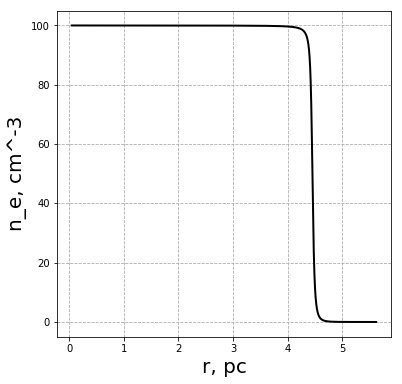

In [546]:
fig, ax = plt.subplots(figsize=(6, 6)) #16:14 is size ratio 

ax.plot(result['r'], result['n_e'], lw=2, c='black') 
ax.grid(c='#aaaaaa', ls='--')
plt.ylabel("n_e, cm^-3", size=20)
plt.xlabel("r, pc", size=20)